<font size="5">Import Libraries</font>

In [41]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, adjusted_rand_score
import torch
from sklearn.linear_model import LogisticRegression
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.inspection import permutation_importance
import shap
import warnings
import seaborn as sns
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings("ignore")

sb.set(rc={'figure.figsize': (12,7)})

gc.enable()
gc.collect()

18607

# Load dataset

In [23]:
def rem_outliers(df):
    s1 = df.shape
    for i in df.select_dtypes(include='number').columns:
        qt1 = df[i].quantile(0.25)
        qt3 = df[i].quantile(0.75)
        iqr = qt3 - qt1
        lower = qt1 - (1.5 * iqr)
        upper = qt3 + (1.5 * iqr)
        min_in = df[df[i] < lower].index
        max_in = df[df[i] > upper].index
        df.drop(min_in, inplace=True)
        df.drop(max_in, inplace=True)
    s2 = df.shape
    outliers = s1[0] - s2[0]
    return outliers

def print_metrics(y_true, y_pred, dataset_name, model_name):
    print(f"\n{model_name} on {dataset_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%")
    print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.2f}")
    print(f"Recall: {recall_score(y_true, y_pred, average='macro'):.2f}")
    print(f"F1-Score: {f1_score(y_true, y_pred, average='macro'):.2f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_true, y_pred)}")

class HybridNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(HybridNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

First few rows:
         obj_ID       alpha      delta         u         g         r  \
0  1.237661e+18  135.689107  32.494632  23.87882  22.27530  20.39501   
1  1.237665e+18  144.826101  31.274185  24.77759  22.83188  22.58444   
2  1.237661e+18  142.188790  35.582444  25.26307  22.66389  20.60976   
3  1.237663e+18  338.741038  -0.402828  22.13682  23.77656  21.61162   
4  1.237680e+18  345.282593  21.183866  19.43718  17.58028  16.49747   

          i         z  run_ID  rerun_ID  cam_col  field_ID   spec_obj_ID  \
0  19.16573  18.79371    3606       301        2        79  6.543777e+18   
1  21.16812  21.61427    4518       301        5       119  1.176014e+19   
2  19.34857  18.94827    3606       301        2       120  5.152200e+18   
3  20.50454  19.25010    4192       301        3       214  1.030107e+19   
4  15.97711  15.54461    8102       301        3       137  6.891865e+18   

    class  redshift  plate    MJD  fiber_ID  
0  GALAXY  0.634794   5812  56354       171  
1 

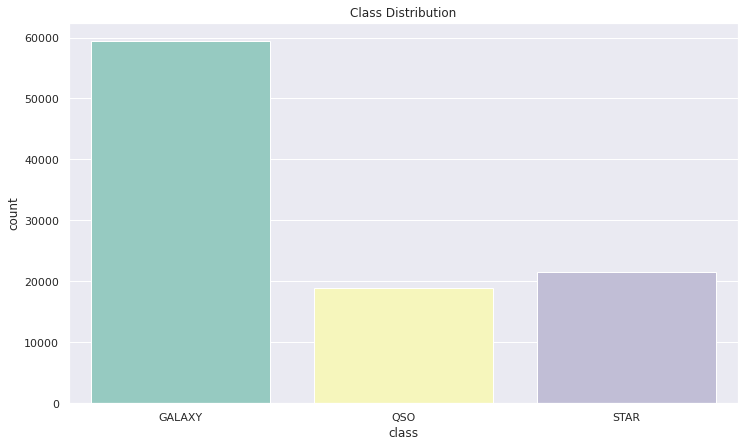

Number of outliers deleted: 14266


2716

In [24]:
star = pd.read_csv('/kaggle/input/stellar-classification-dataset-sdss17/star_classification.csv')
print("First few rows:")
print(star.head())

print("Class Distribution:")
print(star["class"].value_counts(normalize=True) * 100)
sb.countplot(x=star["class"], palette="Set3")
plt.title("Class Distribution")
plt.show()

outliers_removed = rem_outliers(star)
print(f"Number of outliers deleted: {outliers_removed}")

for col in ['u', 'g', 'r', 'i', 'z']:
    star[f'redshift_{col}'] = star['redshift'] * star[col]

columns_to_drop = ['run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'fiber_ID', 'obj_ID']
star.drop(columns=columns_to_drop, axis=1, inplace=True)

le = LabelEncoder()
star["class"] = le.fit_transform(star["class"]) 

X = star.drop('class', axis=1)
y = star['class']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

sc = StandardScaler()
X_train_scaled = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(sc.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(sc.transform(X_test), columns=X_test.columns, index=X_test.index)

oversampler = SMOTE(random_state=1)
X_train_smote, y_train_smote = oversampler.fit_resample(X_train_scaled, y_train)
gc.collect()

# Models

In [25]:
param_grid_knn = {'n_neighbors': [3, 5, 7, 10]}
knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train_smote, y_train_smote)
best_knn = grid_search_knn.best_estimator_
print(f"Best KNN parameters: {grid_search_knn.best_params_}")

y_val_pred_knn = best_knn.predict(X_val_scaled)
print_metrics(y_val, y_val_pred_knn, "Validation Set", "KNN")
y_test_pred_knn = best_knn.predict(X_test_scaled)
print_metrics(y_test, y_test_pred_knn, "Test Set", "KNN")
gc.collect()

Best KNN parameters: {'n_neighbors': 3}

KNN on Validation Set:
Accuracy: 94.17%
Precision: 0.90
Recall: 0.94
F1-Score: 0.92
Confusion Matrix:
[[10428   485   226]
 [  214  1741     7]
 [   65     2  3979]]

KNN on Test Set:
Accuracy: 94.44%
Precision: 0.90
Recall: 0.94
F1-Score: 0.92
Confusion Matrix:
[[10417   447   243]
 [  183  1692     7]
 [   69     4  4085]]


408

In [26]:
bic = []
for n in range(1, 11):
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X_train_smote)
    bic.append(gmm.bic(X_train_smote))
optimal_n = np.argmin(bic) + 1
gmm = GaussianMixture(n_components=optimal_n, random_state=42)
gmm.fit(X_train_smote)
clusters_val = gmm.predict(X_val_scaled)
ari = adjusted_rand_score(y_val, clusters_val)
print(f"GMM Optimal Components: {optimal_n}, Adjusted Rand Index on Validation Set: {ari:.4f}")

clusters_test = gmm.predict(X_test_scaled)
ari_test = adjusted_rand_score(y_test, clusters_test)
print(f"GMM Adjusted Rand Index on Test Set: {ari_test:.4f}")
gc.collect()

GMM Optimal Components: 10, Adjusted Rand Index on Validation Set: 0.2644
GMM Adjusted Rand Index on Test Set: 0.2661


23

In [27]:
param_grid_catboost = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}
catboost = CatBoostClassifier(task_type='GPU' if torch.cuda.is_available() else 'CPU', verbose=0)
grid_search_catboost = GridSearchCV(catboost, param_grid_catboost, cv=5, scoring='accuracy')
grid_search_catboost.fit(X_train_smote, y_train_smote)
best_catboost = grid_search_catboost.best_estimator_
print(f"Best CatBoost parameters: {grid_search_catboost.best_params_}")

catboost_probs_train = best_catboost.predict_proba(X_train_smote)
catboost_probs_val = best_catboost.predict_proba(X_val_scaled)
catboost_probs_test = best_catboost.predict_proba(X_test_scaled)

y_val_pred_catboost = best_catboost.predict(X_val_scaled)
print_metrics(y_val, y_val_pred_catboost, "Validation Set", "CatBoost")
gc.collect()

Best CatBoost parameters: {'depth': 8, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

CatBoost on Validation Set:
Accuracy: 97.21%
Precision: 0.95
Recall: 0.96
F1-Score: 0.96
Confusion Matrix:
[[10853   236    50]
 [  182  1778     2]
 [    9     0  4037]]


24

# Tensor prepping 

In [30]:
X_train_nn = np.hstack((X_train_smote, catboost_probs_train))
X_val_nn = np.hstack((X_val_scaled, catboost_probs_val))
X_test_nn = np.hstack((X_test_scaled, catboost_probs_test))

X_train_tensor = torch.tensor(X_train_nn, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_smote.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_nn, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_nn, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = X_train_nn.shape[1]
nn_model = HybridNN(input_size=input_size, num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

best_val_loss = float('inf')
patience = 5
counter = 0
for epoch in range(100):
    nn_model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    nn_model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            val_outputs = nn_model(X_val_batch)
            val_loss += criterion(val_outputs, y_val_batch).item()
    val_loss /= len(val_loader)
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(nn_model.state_dict(), 'best_nn_model.pt')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

nn_model.load_state_dict(torch.load('best_nn_model.pt'))
gc.collect()

Epoch 1, Validation Loss: 0.1594
Epoch 2, Validation Loss: 0.1619
Epoch 3, Validation Loss: 0.1533
Epoch 4, Validation Loss: 0.1537
Epoch 5, Validation Loss: 0.1575
Epoch 6, Validation Loss: 0.1736
Epoch 7, Validation Loss: 0.1540
Epoch 8, Validation Loss: 0.1513
Epoch 9, Validation Loss: 0.1672
Epoch 10, Validation Loss: 0.1579
Epoch 11, Validation Loss: 0.1571
Epoch 12, Validation Loss: 0.1924
Epoch 13, Validation Loss: 0.1802
Early stopping


35

# Evals and plots

In [33]:
nn_model.eval()
nn_probs_val = []
with torch.no_grad():
    for X_val_batch, _ in val_loader:
        X_val_batch = X_val_batch.to(device)
        outputs = nn_model(X_val_batch)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        nn_probs_val.append(probs)
nn_probs_val = np.vstack(nn_probs_val)
knn_probs_val = best_knn.predict_proba(X_val_scaled)
meta_features_val = np.hstack((catboost_probs_val, nn_probs_val, knn_probs_val))

meta_learner = LogisticRegression()
meta_learner.fit(meta_features_val, y_val)

nn_probs_test = []
with torch.no_grad():
    for X_test_batch, _ in test_loader:
        X_test_batch = X_test_batch.to(device)
        outputs = nn_model(X_test_batch)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        nn_probs_test.append(probs)
nn_probs_test = np.vstack(nn_probs_test)
knn_probs_test = best_knn.predict_proba(X_test_scaled)
meta_features_test = np.hstack((catboost_probs_test, nn_probs_test, knn_probs_test))
y_test_pred_meta = meta_learner.predict(meta_features_test)
print_metrics(y_test, y_test_pred_meta, "Test Set", "Meta-Learner")
gc.collect()


Meta-Learner on Test Set:
Accuracy: 97.37%
Precision: 0.95
Recall: 0.96
F1-Score: 0.96
Confusion Matrix:
[[10860   205    42]
 [  194  1687     1]
 [    9     0  4149]]


24


CatBoost on Test Set:
Accuracy: 97.04%
Precision: 0.94
Recall: 0.96
F1-Score: 0.95
Confusion Matrix:
[[10781   276    50]
 [  173  1708     1]
 [    7     1  4150]]

Neural Network on Test Set:
Accuracy: 96.98%
Precision: 0.94
Recall: 0.96
F1-Score: 0.95
Confusion Matrix:
[[10781   292    34]
 [  179  1702     1]
 [   11     1  4146]]


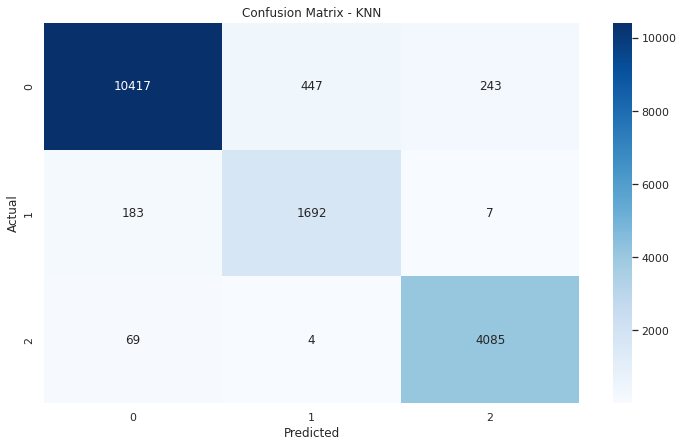

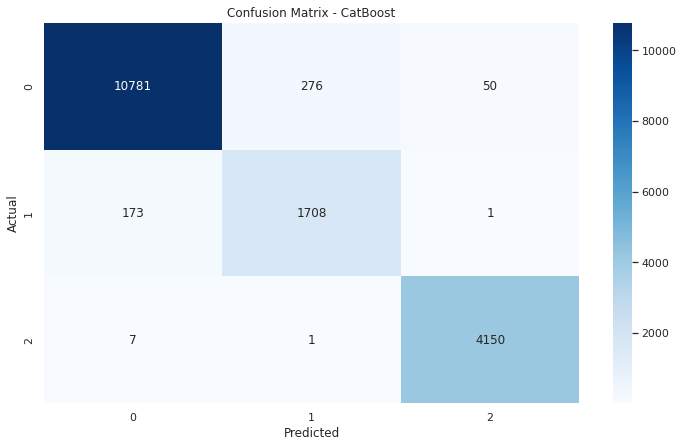

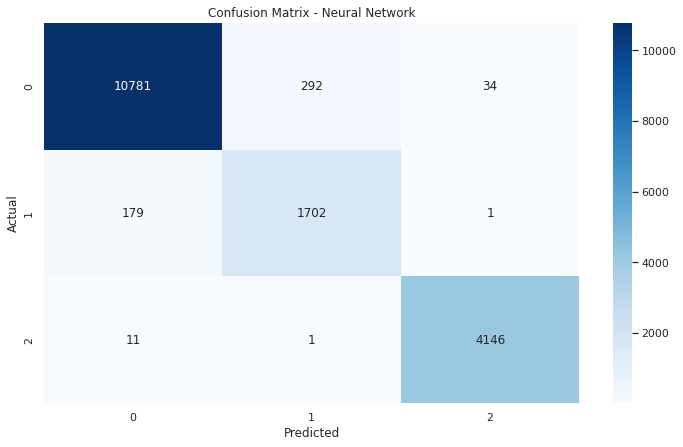

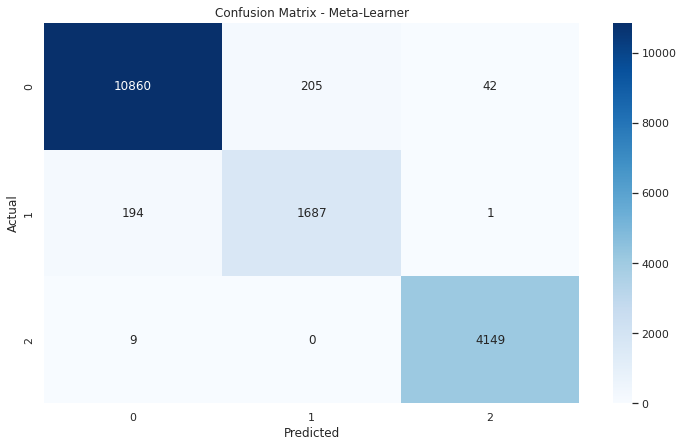

20776

In [34]:
y_test_pred_catboost = best_catboost.predict(X_test_scaled)
print_metrics(y_test, y_test_pred_catboost, "Test Set", "CatBoost")
y_test_pred_nn = []
with torch.no_grad():
    for X_test_batch, _ in test_loader:
        X_test_batch = X_test_batch.to(device)
        outputs = nn_model(X_test_batch)
        _, predicted = torch.max(outputs.data, 1)
        y_test_pred_nn.extend(predicted.cpu().numpy())
print_metrics(y_test, y_test_pred_nn, "Test Set", "Neural Network")

cm_knn = confusion_matrix(y_test, y_test_pred_knn)
sb.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - KNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

cm_catboost = confusion_matrix(y_test, y_test_pred_catboost)
sb.heatmap(cm_catboost, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - CatBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

cm_nn = confusion_matrix(y_test, y_test_pred_nn)
sb.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Neural Network')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

cm_meta = confusion_matrix(y_test, y_test_pred_meta)
sb.heatmap(cm_meta, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Meta-Learner')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
gc.collect()


KNN on Training Set:
Accuracy: 98.48%
Precision: 0.99
Recall: 0.98
F1-Score: 0.98
Confusion Matrix:
[[31939   903   497]
 [   98 33237     4]
 [   18     1 33320]]

KNN on Validation Set:
Accuracy: 94.17%
Precision: 0.90
Recall: 0.94
F1-Score: 0.92
Confusion Matrix:
[[10428   485   226]
 [  214  1741     7]
 [   65     2  3979]]

KNN on Test Set:
Accuracy: 94.44%
Precision: 0.90
Recall: 0.94
F1-Score: 0.92
Confusion Matrix:
[[10417   447   243]
 [  183  1692     7]
 [   69     4  4085]]


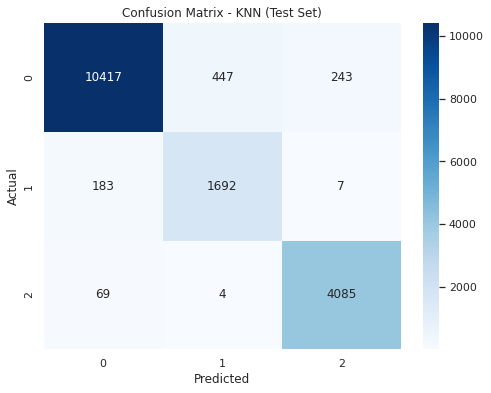


GMM on Training Set: Adjusted Rand Index = 0.3918
GMM on Validation Set: Adjusted Rand Index = 0.2644
GMM on Test Set: Adjusted Rand Index = 0.2661


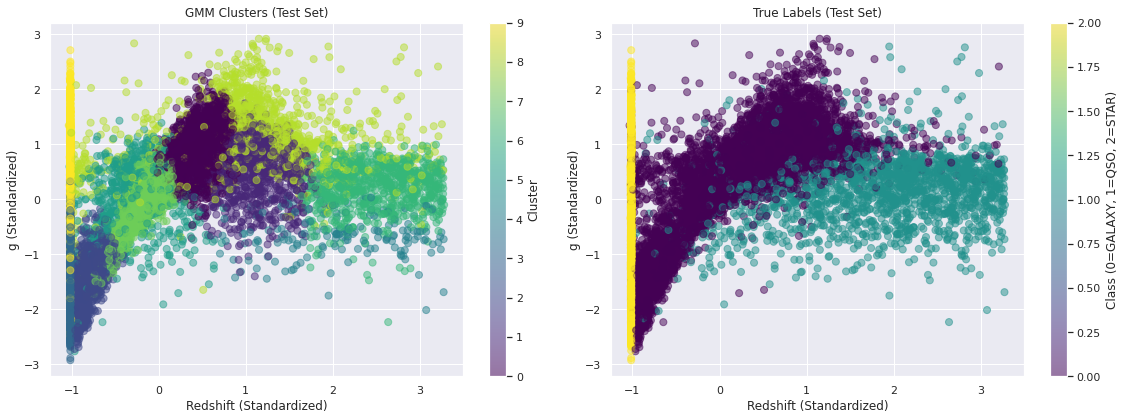

16323

In [37]:
y_train_pred_knn = best_knn.predict(X_train_smote)
print_metrics(y_train_smote, y_train_pred_knn, "Training Set", "KNN")

y_val_pred_knn = best_knn.predict(X_val_scaled)
print_metrics(y_val, y_val_pred_knn, "Validation Set", "KNN")

y_test_pred_knn = best_knn.predict(X_test_scaled)
print_metrics(y_test, y_test_pred_knn, "Test Set", "KNN")

cm_knn = confusion_matrix(y_test, y_test_pred_knn)
plt.figure(figsize=(8, 6))
sb.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - KNN (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

clusters_train = gmm.predict(X_train_smote)
ari_train = adjusted_rand_score(y_train_smote, clusters_train)
print(f"\nGMM on Training Set: Adjusted Rand Index = {ari_train:.4f}")

clusters_val = gmm.predict(X_val_scaled)
ari_val = adjusted_rand_score(y_val, clusters_val)
print(f"GMM on Validation Set: Adjusted Rand Index = {ari_val:.4f}")

clusters_test = gmm.predict(X_test_scaled)
ari_test = adjusted_rand_score(y_test, clusters_test)
print(f"GMM on Test Set: Adjusted Rand Index = {ari_test:.4f}")

X_test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_test_df['redshift'], X_test_df['g'], c=clusters_test, cmap='viridis', s=50, alpha=0.5)
plt.title('GMM Clusters (Test Set)')
plt.xlabel('Redshift (Standardized)')
plt.ylabel('g (Standardized)')
plt.colorbar(label='Cluster')

plt.subplot(1, 2, 2)
plt.scatter(X_test_df['redshift'], X_test_df['g'], c=y_test, cmap='viridis', s=50, alpha=0.5)
plt.title('True Labels (Test Set)')
plt.xlabel('Redshift (Standardized)')
plt.ylabel('g (Standardized)')
plt.colorbar(label='Class (0=GALAXY, 1=QSO, 2=STAR)')

plt.tight_layout()
plt.show()

gc.collect()

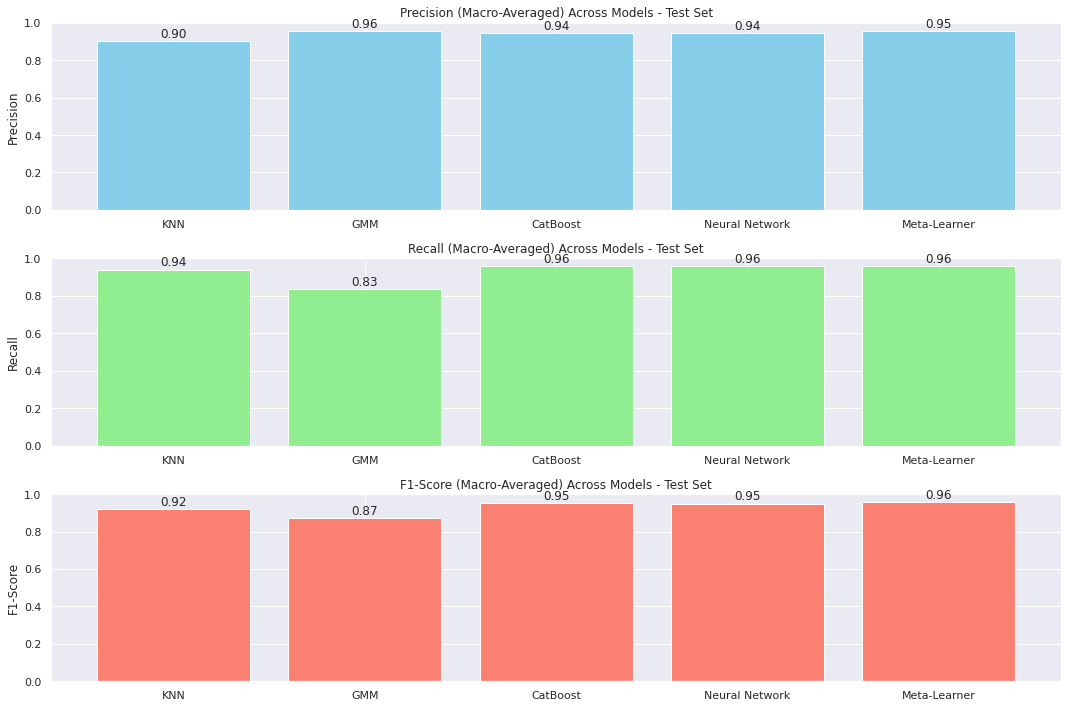

9073

In [38]:
y_test_pred_knn = best_knn.predict(X_test_scaled)
knn_precision = precision_score(y_test, y_test_pred_knn, average='macro')
knn_recall = recall_score(y_test, y_test_pred_knn, average='macro')
knn_f1 = f1_score(y_test, y_test_pred_knn, average='macro')

clusters_test = gmm.predict(X_test_scaled)
cluster_to_class = {}
for cluster in np.unique(clusters_test):
    mask = clusters_test == cluster
    majority_class = y_test[mask].mode()[0]  
    cluster_to_class[cluster] = majority_class
y_test_pred_gmm = np.array([cluster_to_class[cluster] for cluster in clusters_test])
gmm_precision = precision_score(y_test, y_test_pred_gmm, average='macro')
gmm_recall = recall_score(y_test, y_test_pred_gmm, average='macro')
gmm_f1 = f1_score(y_test, y_test_pred_gmm, average='macro')

y_test_pred_catboost = best_catboost.predict(X_test_scaled)
catboost_precision = precision_score(y_test, y_test_pred_catboost, average='macro')
catboost_recall = recall_score(y_test, y_test_pred_catboost, average='macro')
catboost_f1 = f1_score(y_test, y_test_pred_catboost, average='macro')

nn_model.eval()
y_test_pred_nn = []
with torch.no_grad():
    for X_test_batch, _ in test_loader:
        X_test_batch = X_test_batch.to(device)
        outputs = nn_model(X_test_batch)
        _, predicted = torch.max(outputs.data, 1)
        y_test_pred_nn.extend(predicted.cpu().numpy())
nn_precision = precision_score(y_test, y_test_pred_nn, average='macro')
nn_recall = recall_score(y_test, y_test_pred_nn, average='macro')
nn_f1 = f1_score(y_test, y_test_pred_nn, average='macro')

y_test_pred_meta = meta_learner.predict(meta_features_test)
meta_precision = precision_score(y_test, y_test_pred_meta, average='macro')
meta_recall = recall_score(y_test, y_test_pred_meta, average='macro')
meta_f1 = f1_score(y_test, y_test_pred_meta, average='macro')

models = ['KNN', 'GMM', 'CatBoost', 'Neural Network', 'Meta-Learner']
precisions = [knn_precision, gmm_precision, catboost_precision, nn_precision, meta_precision]
recalls = [knn_recall, gmm_recall, catboost_recall, nn_recall, meta_recall]
f1_scores = [knn_f1, gmm_f1, catboost_f1, nn_f1, meta_f1]

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.bar(models, precisions, color='skyblue')
plt.title('Precision (Macro-Averaged) Across Models - Test Set')
plt.ylabel('Precision')
plt.ylim(0, 1)
for i, v in enumerate(precisions):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center')

plt.subplot(3, 1, 2)
plt.bar(models, recalls, color='lightgreen')
plt.title('Recall (Macro-Averaged) Across Models - Test Set')
plt.ylabel('Recall')
plt.ylim(0, 1)
for i, v in enumerate(recalls):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center')

plt.subplot(3, 1, 3)
plt.bar(models, f1_scores, color='salmon')
plt.title('F1-Score (Macro-Averaged) Across Models - Test Set')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()

gc.collect()

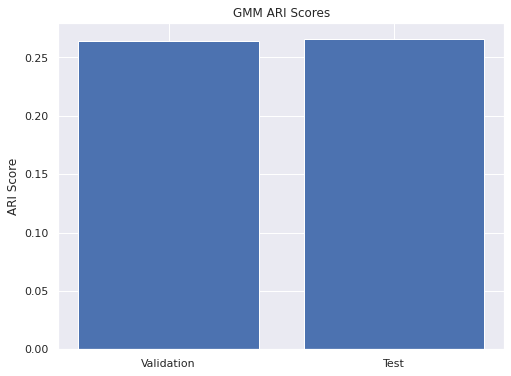

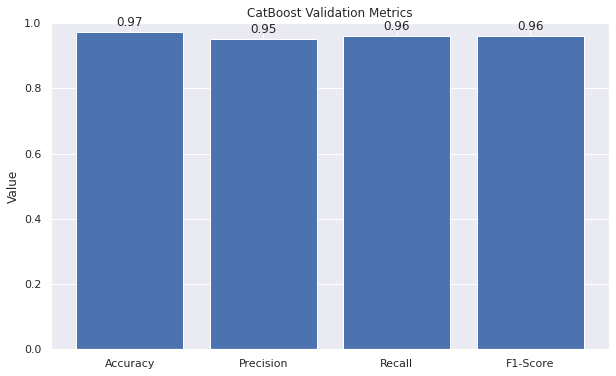

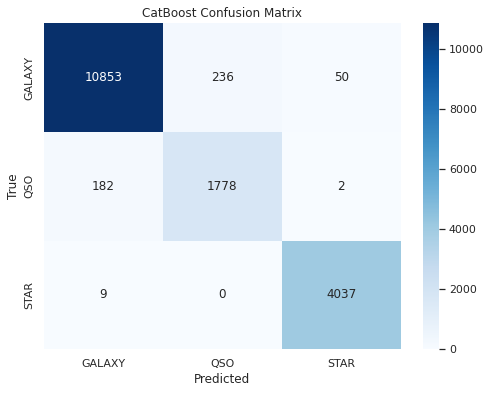

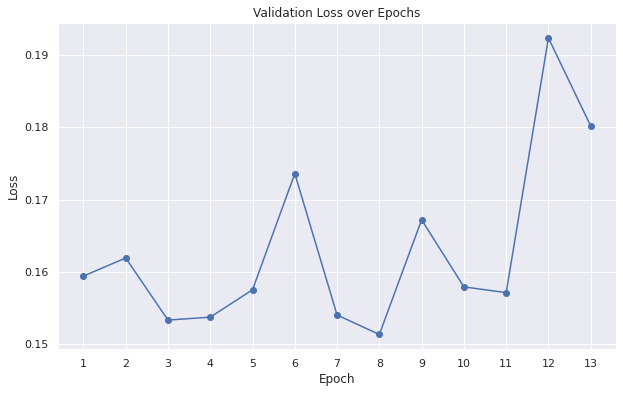

In [42]:
ari_val = 0.2644
ari_test = 0.2661
plt.figure(figsize=(8, 6))
plt.bar(['Validation', 'Test'], [ari_val, ari_test])
plt.title('GMM ARI Scores')
plt.ylabel('ARI Score')
plt.show()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [97.21 / 100, 0.95, 0.96, 0.96]  
plt.figure(figsize=(10, 6))
plt.bar(metrics, values)
plt.title('CatBoost Validation Metrics')
plt.ylabel('Value')
plt.ylim(0, 1)
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center')
plt.show()

conf_matrix = np.array([[10853, 236, 50], [182, 1778, 2], [9, 0, 4037]])
class_names = ['GALAXY', 'QSO', 'STAR']  
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('CatBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

epochs = range(1, 14)
val_loss = [0.1594, 0.1619, 0.1533, 0.1537, 0.1575, 0.1736, 0.1540, 0.1513, 0.1672, 0.1579, 0.1571, 0.1924, 0.1802]
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_loss, marker='o')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid(True)
plt.show()

In [35]:
new_data = X_test.sample(5, random_state=42)
new_data_scaled = pd.DataFrame(sc.transform(new_data), columns=new_data.columns)

catboost_probs_new = best_catboost.predict_proba(new_data_scaled)
nn_probs_new = []
new_tensor = torch.tensor(np.hstack((new_data_scaled, catboost_probs_new)), dtype=torch.float32).to(device)
with torch.no_grad():
    outputs = nn_model(new_tensor)
    nn_probs_new = torch.softmax(outputs, dim=1).cpu().numpy()
knn_probs_new = best_knn.predict_proba(new_data_scaled)
meta_features_new = np.hstack((catboost_probs_new, nn_probs_new, knn_probs_new))

new_predictions = meta_learner.predict(meta_features_new)
new_predictions_labels = le.inverse_transform(new_predictions)
print("\nInference Pipeline Results:")
for i, pred in enumerate(new_predictions_labels):
    print(f"Sample {i+1}: Predicted Class = {pred}")
gc.collect()


Inference Pipeline Results:
Sample 1: Predicted Class = GALAXY
Sample 2: Predicted Class = GALAXY
Sample 3: Predicted Class = STAR
Sample 4: Predicted Class = GALAXY
Sample 5: Predicted Class = GALAXY


47

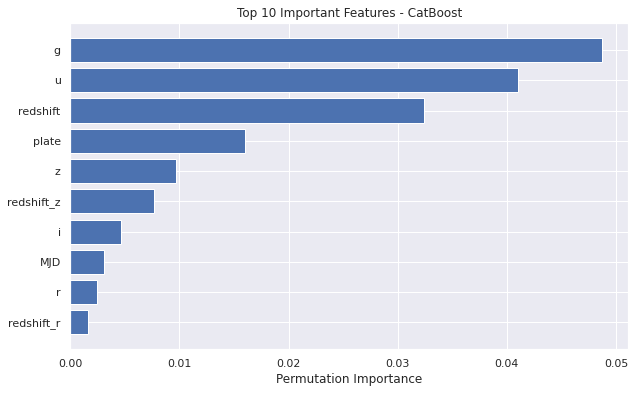

  0%|          | 0/100 [00:00<?, ?it/s]

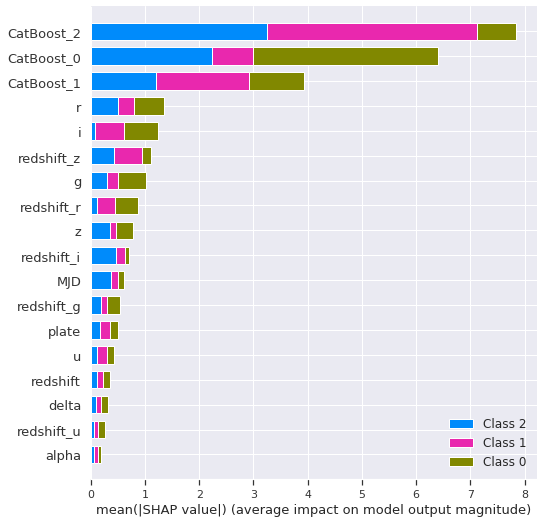

11013

In [36]:
result = permutation_importance(best_catboost, X_test_scaled, y_test, n_repeats=10, random_state=42)
importances = result.importances_mean
sorted_idx = importances.argsort()[::-1]
plt.figure(figsize=(10,6))
plt.barh(X_test.columns[sorted_idx][:10], importances[sorted_idx][:10])
plt.xlabel('Permutation Importance')
plt.title('Top 10 Important Features - CatBoost')
plt.gca().invert_yaxis()
plt.show()

explainer = shap.KernelExplainer(lambda x: nn_model(torch.tensor(x, dtype=torch.float32).to(device)).detach().cpu().numpy(), X_train_nn[:100])
shap_values = explainer.shap_values(X_test_nn[:100])
shap.summary_plot(shap_values, X_test_nn[:100], feature_names=list(X_test.columns) + ['CatBoost_0', 'CatBoost_1', 'CatBoost_2'], plot_type="bar")
gc.collect()